# BI-PRS: semestrální projekt 2

Cílem druhého semestrálního projektu je prozkoumat závislost konkrétní proměnné na různých regresorech z přiřazeného datasetu.

Náš tým se skládá ze tří lidí: Ruslana Orazbekova (orazbrus), Nelly Shikina (shikinel), Daria Sychova (sychodar). Reprezentatntem ve druhém semestrálním projektu je Daria Sychova. Nejprve určíme, který soubor dat a kterou proměnnou budeme v rámci semestrálního projektu analyzovat.

In [2]:
# K = den narození reprezentanta skupiny (1-31)
# L = počet písmen v příjmení reprezentanta
# M = ((K+L)×47)mod11+1

K <- 10
L <- nchar('Sychova')
M <- ((K + L) * 47) %% 11 + 1
print(M)

[1] 8


Máme teda dataset **ex0918**:

> Researchers studied the development of a fly (Drosophila subobscura) that had been accidentally introduced from the Old World into North America around 1980
>
**Vysvětlovaná proměnná:** Ratio
**Popis:** Poměr velikosti křídel ku délce much

## Úloha 1

#### Načtěme knihovny a požadovanou datovou sadu.

In [22]:
library(Sleuth2)
library(mgcv)
library(ggplot2)
library(graphics)
library(corrplot)
library(reshape2)

In [4]:
data(ex0918)

In [5]:
str(ex0918)

'data.frame':	21 obs. of  8 variables:
 $ Continent: Factor w/ 2 levels "NA","EU": 1 1 1 1 1 1 1 1 1 2 ...
 $ Latitude : num  35.5 37 38.6 40.7 40.9 42.4 45 46.8 48.8 49.8 ...
 $ Females  : num  901 896 906 907 898 893 913 915 927 924 ...
 $ SE.F     : num  2.5 3.5 3 3.5 3.6 3.4 4.3 3.8 2 4.5 ...
 $ Males    : num  797 806 812 807 818 809 810 819 800 823 ...
 $ SE.M     : num  3.8 3 3.2 3.2 2.7 3.3 4.3 3.3 4.9 2.2 ...
 $ Ratio    : num  0.831 0.834 0.836 0.833 0.83 0.828 0.834 0.825 0.832 0.824 ...
 $ SE.R     : num  0.01 0.014 0.012 0.013 0.012 0.015 0.024 0.014 0.009 0.011 ...


#### Data structure
**Continent:** a factor with levels "NA" and "EU"

**Latitude:** latitude (degrees)

**Females:** average wing size (103×log mm) of female flies on log scale

**SE.F:** standard error of wing size (103×log mm) of female flies on log scale

**Males:** average wing size (103×log mm) of male flies on log scale

**SE.M:** standard error of wing size (103×log mm) of male flies on log scale

**Ratio:** average basal length to wing size ratios of female flies

**SE.R:** standard error of average basal length to wing size ratio of female flies

In [6]:
head(ex0918)

,Continent,Latitude,Females,SE.F,Males,SE.M,Ratio,SE.R
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,35.5,901,2.5,797,3.8,0.831,0.010
2,NA,37.0,896,3.5,806,3.0,0.834,0.014
3,NA,38.6,906,3.0,812,3.2,0.836,0.012
4,NA,40.7,907,3.5,807,3.2,0.833,0.013
5,NA,40.9,898,3.6,818,2.7,0.830,0.012
6,NA,42.4,893,3.4,809,3.3,0.828,0.015


In [7]:
summary(ex0918)

 Continent    Latitude       Females         SE.F           Males      
 NA: 9     Min.   :35.5   Min.   :889   Min.   :2.000   Min.   :789.0  
 EU:12     1st Qu.:40.7   1st Qu.:901   1st Qu.:3.200   1st Qu.:807.0  
           Median :45.0   Median :915   Median :3.500   Median :812.0  
           Mean   :44.6   Mean   :914   Mean   :3.652   Mean   :815.1  
           3rd Qu.:48.8   3rd Qu.:926   3rd Qu.:4.300   3rd Qu.:819.0  
           Max.   :56.1   Max.   :944   Max.   :6.100   Max.   :855.0  
      SE.M           Ratio            SE.R        
 Min.   :2.200   Min.   :0.809   Min.   :0.00700  
 1st Qu.:3.100   1st Qu.:0.824   1st Qu.:0.01200  
 Median :3.300   Median :0.826   Median :0.01300  
 Mean   :3.724   Mean   :0.827   Mean   :0.01476  
 3rd Qu.:4.300   3rd Qu.:0.832   3rd Qu.:0.01600  
 Max.   :6.200   Max.   :0.836   Max.   :0.03200  

Vidíme, že údaje pro female a male se významně neliší. Standard error pro female od 2.000 do 6.100 pro male od 2.200 do 6.200. Ověříme přitomnost NaN hodnot:

In [8]:
# Checking if we have NaN values
any_na <- any(is.na(ex0918))
print(any_na)

[1] FALSE


We don't have any NaN values, which is fine. Now let's plot a histogram for (add smth...)

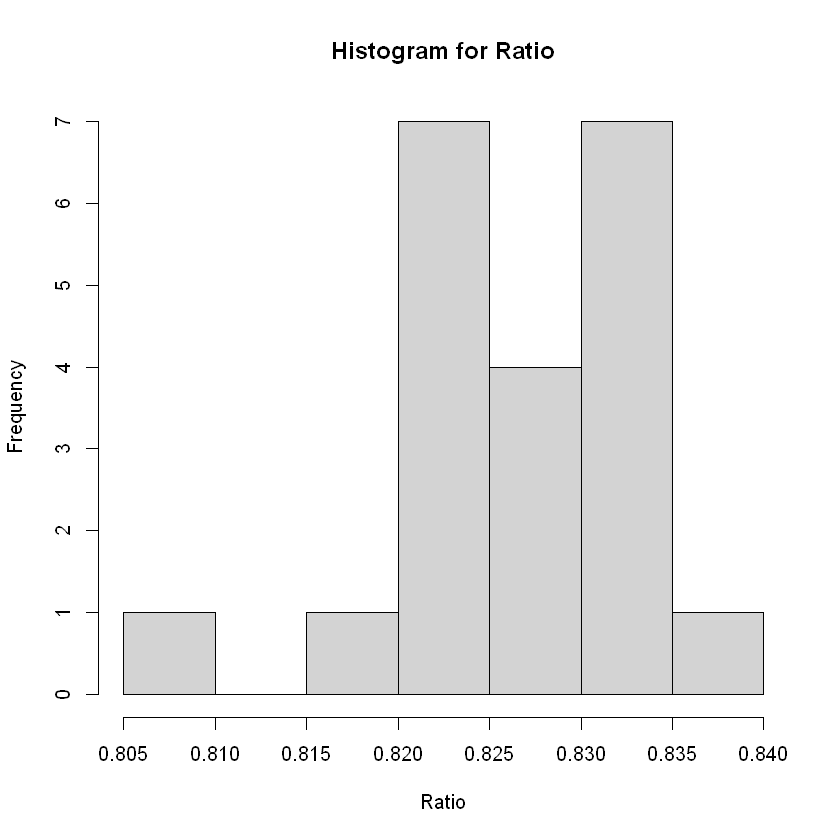

In [9]:
hist(ex0918$Ratio, main="Histogram for Ratio", xlab="Ratio")

Tento histogram zobrazuje rozdělení proměnné 'Ratio'. Většina datových bodů se shromažďuje ve středních hodnotách. Histogram naznačuje, že distribuce proměnné 'Ratio' není rovnoměrná a ukazuje na bimodální nebo jine ne-standardní rozdělení dat.

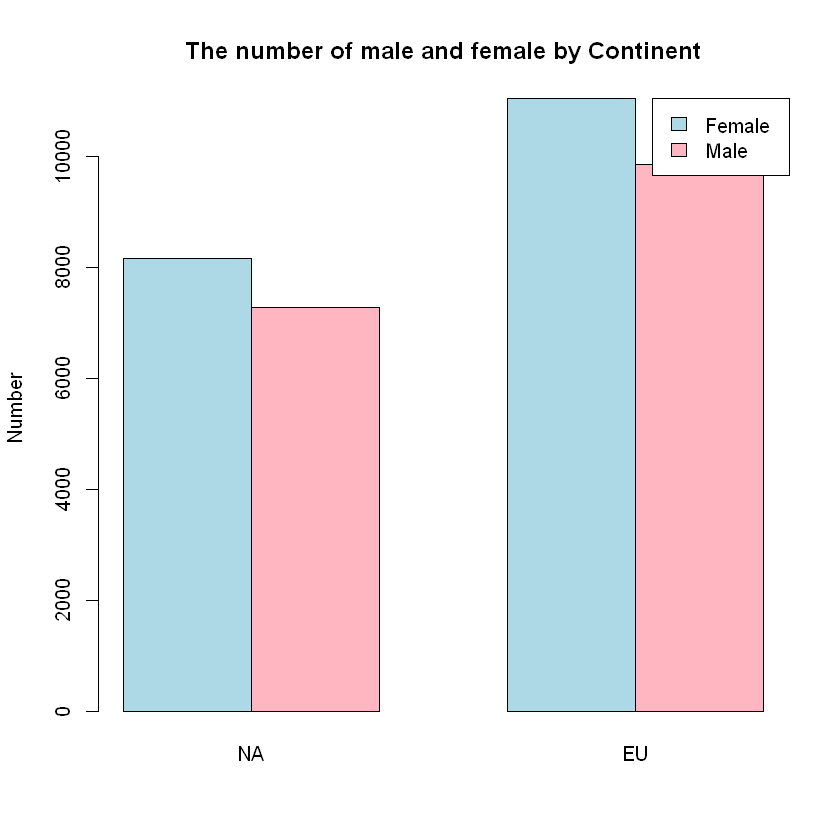

In [10]:
sum_females <- aggregate(Females ~ Continent, data = ex0918, sum)
sum_males <- aggregate(Males ~ Continent, data = ex0918, sum)

# Vytvoření sloupcového grafu
barplot(rbind(sum_females$Females, sum_males$Males), 
        beside = TRUE, 
        col = c("lightblue", "lightpink"),
        names.arg = sum_females$Continent,
        legend.text = c("Female", "Male"),
        args.legend = list(x = "topright"),
        main = "The number of male and female by Continent",
        ylab = "Number")

Na základě tohoto grafu vidíme, že počet samcu mírně převyšuje počet samic na obou kontinentech. Také počet much v Evropě je obecně vyšší než v Severní Americe.

In [19]:
# Výpočet korelační matice
cor_matrix <- cor(ex0918[, c("Ratio", "SE.F", "Females", "Males")], use = "complete.obs")

# Zobrazení korelační matice
print(cor_matrix)

              Ratio        SE.F     Females       Males
Ratio    1.00000000 -0.38049795  0.08537879 -0.10747256
SE.F    -0.38049795  1.00000000 -0.10542306  0.07229933
Females  0.08537879 -0.10542306  1.00000000  0.67365243
Males   -0.10747256  0.07229933  0.67365243  1.00000000


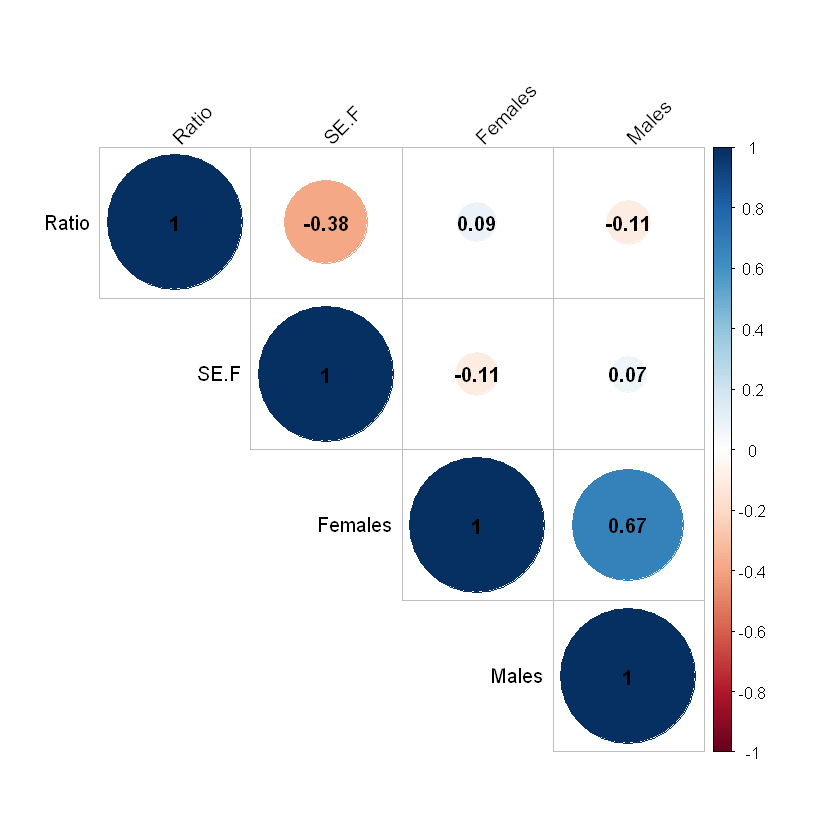

In [24]:
# мizualizace korelační matice pomocí corrplot
corrplot(cor_matrix, method = "circle", type = "upper", order = "hclust",
         tl.col = "black", tl.srt = 45, addCoef.col = "black")

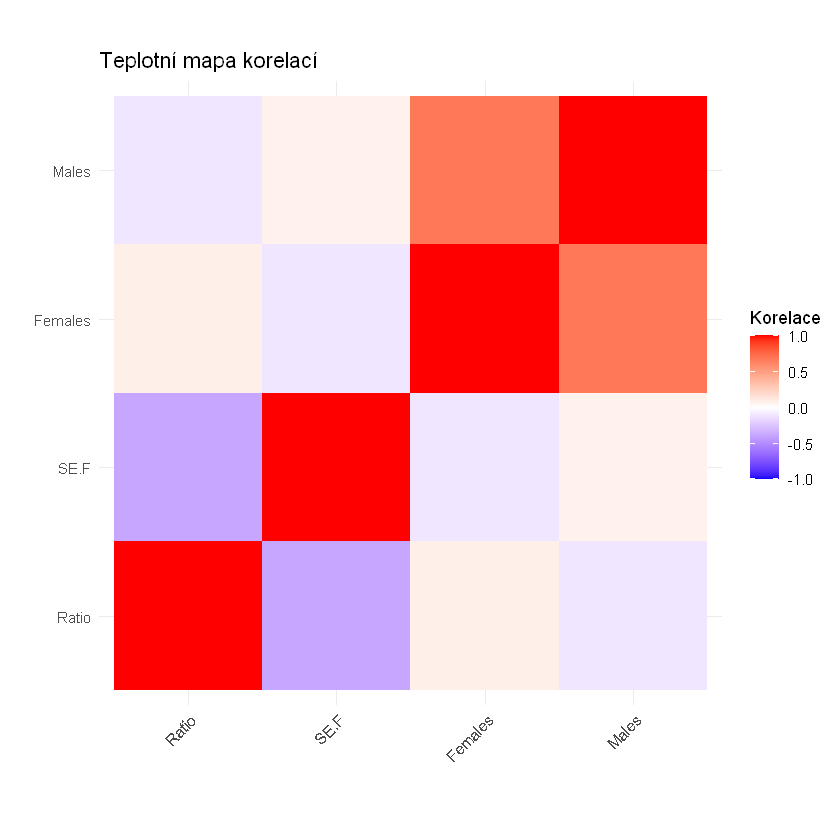

In [25]:
# vytvoření teplotní mapy pomocí ggplot2
data_melt <- reshape2::melt(cor_matrix)
ggplot(data_melt, aes(Var1, Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab", name="Korelace") +
  theme_minimal() +
  coord_fixed() +
  labs(x = "", y = "", title = "Teplotní mapa korelací") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Korelace mezi proměnnými ukazuje silný vztah mezi počtem samců a samic (0.67365243), zatímco proměnná SE.F má negativní vztah k Ratio (-0.38049795), což naznačuje, že vyšší standardní chyba samice může vést k nižší hodnotě Ratio.

## Úloha 2

#### Zkoumejme závislost vysvětlované proměnné na tomto regresoru.


Call:
lm(formula = Ratio ~ SE.F, data = ex0918)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0153799 -0.0016312  0.0008674  0.0028690  0.0086197 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.836135   0.005264 158.845   <2e-16 ***
SE.F        -0.002501   0.001395  -1.793   0.0888 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00609 on 19 degrees of freedom
Multiple R-squared:  0.1448,	Adjusted R-squared:  0.09977 
F-statistic: 3.216 on 1 and 19 DF,  p-value: 0.08883


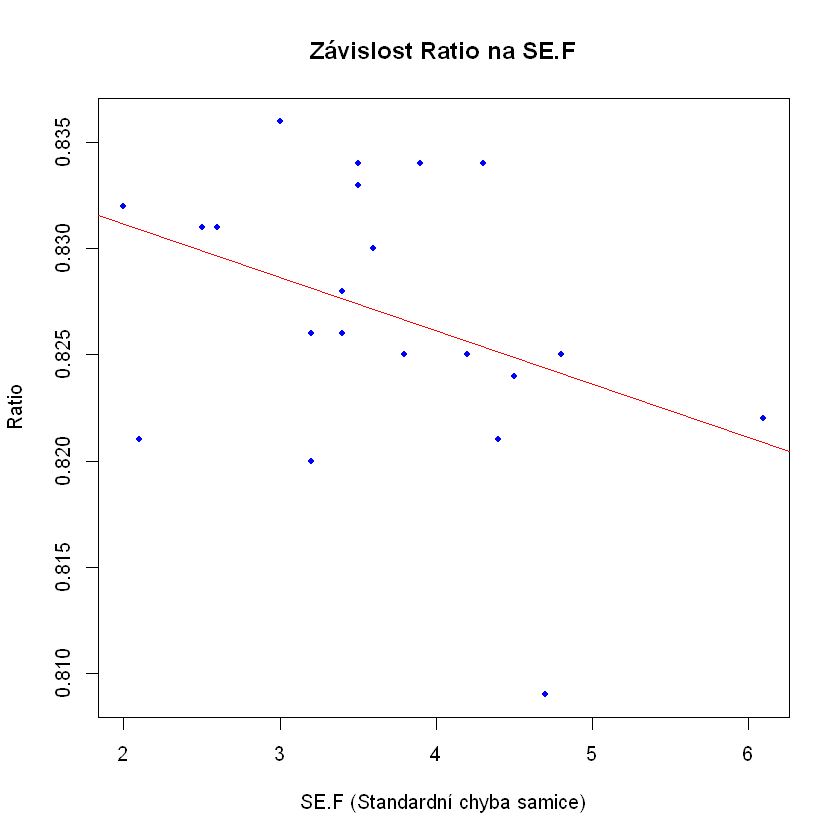

In [11]:
# Lineární regresní model SE.R jako funkce SE.F
model_SE <- lm(Ratio ~ SE.F	, data = ex0918)

# Zobrazení výsledků modelu
summary(model_SE)

# Grafické zobrazení modelu s bodovým grafem a regresní linií
plot(ex0918$SE.F, ex0918$Ratio, 
     main = "Závislost Ratio na SE.F", 
     xlab = "SE.F (Standardní chyba samice)", 
     ylab = "Ratio", 
     pch = 20, 
     col = "blue")

# Přidání regresní linie do grafu
abline(model_SE, col = "red")

Podle výsledků regresní analýzy a grafu můžeme dělat následující závěry:

* Koeficienty modelu: hodnota interceptu (průsečík s osou y) je přibližně 0.836, což naznačuje, že kdyby byla standardní chyba samice (SE.F) nula, očekávaná hodnota poměru (Ratio) by byla právě tato hodnota. Koeficient pro SE.F je negativní (-0.0025) a jeho p-hodnota je těsně nad tradiční hranicí statistické významnosti (0.0888), což znamená, že existuje možná negativní závislost mezi SE.F a Ratio, ale není považována za statisticky významnou.

* Kvalita modelu: hodnota R-kvadrátu (R²) je 0.1448, což značí, že model vysvětluje přibližně 14.48% variability Ratio. To je relativně nízké a ukazuje, že SE.F není silným prediktorem pro Ratio. Upravený R-kvadrát je také nízký (0.0997), což podtrhuje, že model má omezenou predikční hodnotu.

* Vizualizace modelu: graf ukazuje, že s nárůstem SE.F má tendenci klesat i Ratio, což je v souladu s negativním koeficientem uvedeným ve výsledcích modelu. Vztah mezi SE.F a Ratio je však slabý, jak naznačuje nízká hodnota R-kvadrátu a téměř hranice statistické významnosti p-hodnoty.

* Závěr: tento model naznačuje možnou negativní závislost mezi SE.F a Ratio, ale tato závislost není silná a není statisticky významná na tradiční úrovni 0.05.

add ex-post analysis (analyza rezidui, hodnoceni presnosti predikci)

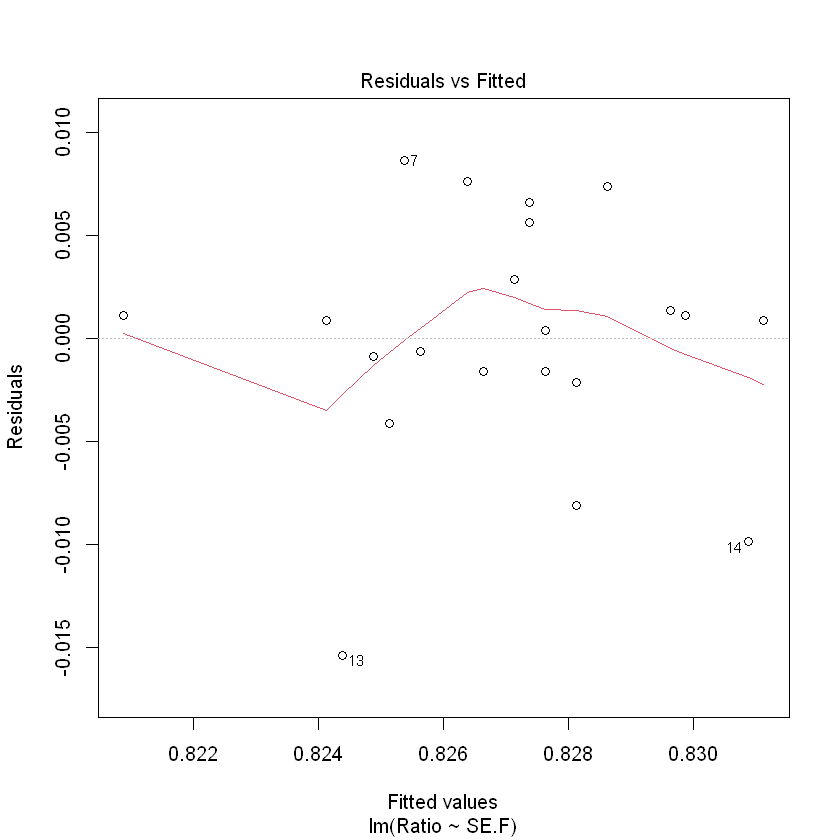

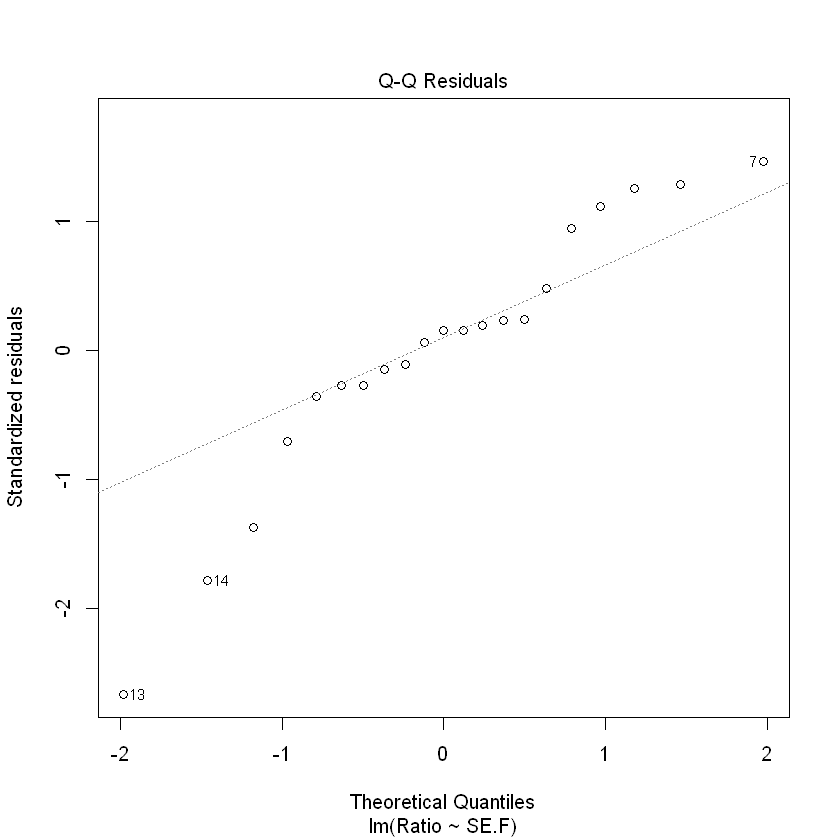

In [13]:
# Diagnostika modelu
plot(model_SE, which = 1)  # Reziduální graf
plot(model_SE, which = 2)  # QQ plot reziduí


Vzhledem k analýze reziduí a QQ grafu můžeme konstatovat, že model prokazuje některé odchylky od předpokladu normálního rozdělení reziduí, avšak celkově je aproximace dostatečná pro další interpretace výsledků.

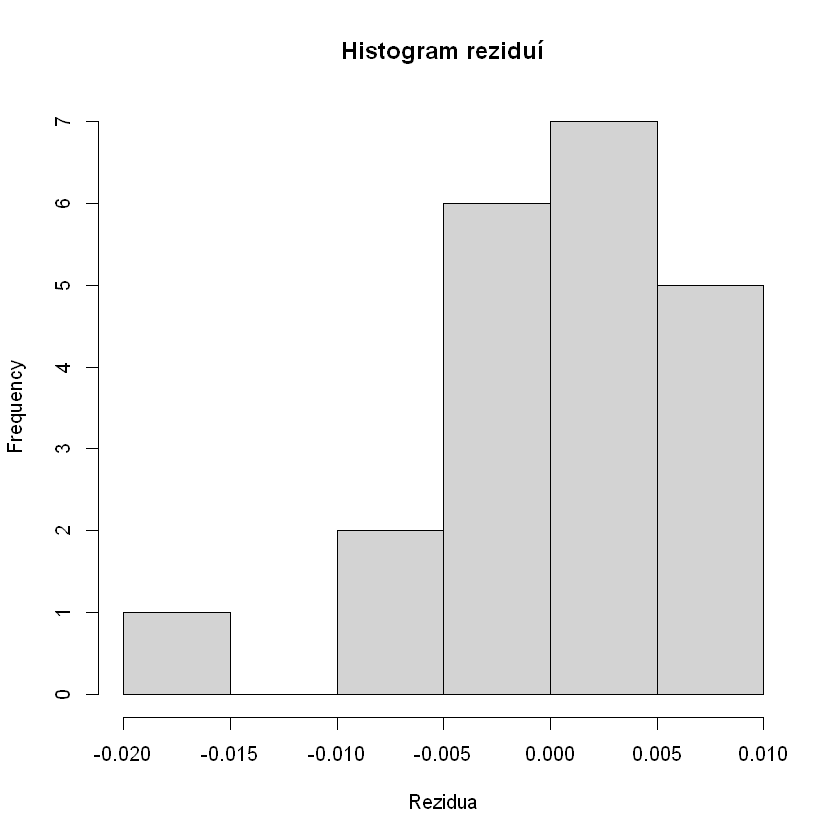

In [17]:
# Ex-post analýza reziduí
residuals_SE <- resid(model_SE)
hist(residuals_SE, main="Histogram reziduí", xlab="Rezidua")

Histogram reziduí naznačuje mírně asymetrické rozdělení s vyšší koncentrací pozitivních hodnot, což by mohlo ukazovat na potenciální problémy s předpokladem homoskedasticity a normálního rozdělení reziduí v modelu.


In [15]:
# Kontrola normality reziduí
shapiro.test(residuals_SE)



	Shapiro-Wilk normality test

data:  residuals_SE
W = 0.92743, p-value = 0.1223


Výsledek Shapiro-Wilkova testu normality pro rezidua, s W hodnotou 0.92743 a p-hodnotou 0.1223, naznačuje, že není dostatek důkazů pro zamítnutí hypotézy o normálním rozdělení reziduálních hodnot na tradiční úrovni významnosti 0.05. To znamená, že předpoklad normálního rozdělení reziduí v tomto modelu je obecně přijatelný.


In [18]:
# Analýza vlivu
influence_data <- influence.measures(model_SE)
print(influence_data)


Influence measures of
	 lm(formula = Ratio ~ SE.F, data = ex0918) :

     dfb.1_ dfb.SE.F   dffit cov.r   cook.d    hat inf
1   0.06289 -0.05346  0.0694 1.257 0.002535 0.1172    
2   0.10222 -0.04014  0.2542 1.023 0.031880 0.0488    
3   0.26394 -0.19750  0.3496 1.008 0.059173 0.0699    
4   0.08594 -0.03375  0.2137 1.064 0.022975 0.0488    
5   0.03232 -0.00581  0.1059 1.142 0.005845 0.0478    
6   0.00690 -0.00359  0.0140 1.174 0.000104 0.0510    
7  -0.13899  0.23318  0.4149 0.942 0.080545 0.0696    
8  -0.00615 -0.00928 -0.0606 1.162 0.001932 0.0488    
9   0.07220 -0.06486  0.0749 1.373 0.002955 0.1908   *
10  0.02042 -0.02986 -0.0449 1.215 0.001064 0.0853    
11 -0.03056  0.01591 -0.0621 1.165 0.002029 0.0510    
12 -0.13701  0.15761  0.1691 1.736 0.015055 0.3617   *
13  0.61512 -0.83357 -1.1269 0.486 0.418795 0.1052   *
14 -0.83638  0.74505 -0.8742 0.934 0.335697 0.1740    
15  0.07058 -0.05900  0.0796 1.238 0.003334 0.1057    
16  0.08011 -0.12406 -0.2010 1.145 0.020761 0.0769 

Analýza vlivových měr vašeho lineárního modelu ukazuje několik pozorování, které by mohly mít významný vliv na model:  
* Pozorování 13: toto pozorování má vysoké hodnoty v dfbeta a dffit, což značí velký vliv na parametry modelu a celkové predikce. Navíc má vysokou hodnotu Cookova d (0.418795), což naznačuje, že může silně ovlivňovat celkovou fitu model
* Pozorování 14 a 12: mají také vysoké hodnoty Cookova d (0.335697 a 0.015055), což naznačuje, že také mohou mít významný vliv na model, přičemž pozorování 14 má vysoké hodnoty dfbeta.
* Pozorování 7: zobrazuje vyšší hodnotu Cookova d (0.080545) a vysoké hodnoty dfbeta, což naznačuje jeho potenciální vliv na odhady koeficientů modelu.

## Úloha 3

V této úloze zvolíme jako regresor nějakou kategoriální proměnnou. Vzhledem k povaze poskytnutých proměnných můžeme jako kategoriální regresor zvolit proměnnou **Continent**. Ta rozděluje data do dvou odlišných skupin: "NA" (Severní Amerika) a "EU" (Evropa). Tato proměnná reprezentuje různé geografické oblasti a je rozumné předpokládat, že mouchy z různých kontinentů mohou vykazovat různé charakteristiky z hlediska velikosti nebo poměru křídel.

In [12]:
# Fit the ANOVA model
anova_model <- aov(Ratio ~ Continent, data = ex0918)

# Check ANOVA table
summary(anova_model)

            Df    Sum Sq   Mean Sq F value  Pr(>F)   
Continent    1 0.0003111 3.111e-04   11.53 0.00304 **
Residuals   19 0.0005129 2.699e-05                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

#### Interpretace tabulky
**Df**: Stupeň volnosti modelu.

**Sum Sq**: Součty čtverců, představující variabilitu, kterou je model schopen zohlednit.

**Mean Sq**: Průměrný čtverec je součet čtverců dělený počtem stupňů volnosti.

**F-value**: Toto je poměr variance vysvětlené modelem k reziduální varianci.

**Pr(>F)**: F-statistická p-hodnota, která označuje statistickou významnost faktorů.

**Residuals**: Relativní odchylky od skupinového průměru se často označují jako rezidua a jejich souhrnné statistiky.

Stanovíme příslušné hypotézy.

**H0**: Neexistují žádné statisticky významné rozdíly mezi skupinovými průměry v proměnné Ratio mezi různými kontinenty.

**HA**: Existují statisticky významné rozdíly mezi skupinovými průměry v proměnné Ratio mezi různými kontinenty.

F-value pro proměnnou Continent je 11.53, což znamená, že mezi skupinovými průměry jsou signifikantní rozdíly. 
Zároveň  Pr(>F) (p-hodnota) je rovna 0,00304, což nám říká, že jsou poměrně významné rozdíly mezi skupinovými průměry statisticky. V našem případě je p-hodnota pro Continent menší než konvenční hladina významnosti 0,05 (indikovaná **), což naznačuje, že existuje statisticky významný rozdíl v proměnné Ratio mezi kontinenty.

Vzhledem k tomu, že p-hodnota pro Continent je menší než konvenční hladina významnosti 0,01 a F-statistika je významná, můžeme tvrdit, že proměnná Continent je statisticky významným prediktorem proměnné Ratio. Nulovou hypotézu **zamítáme**.

Nyní vyhodnotíme kvalitu modelu.

In [13]:
# Extract sums of squares from ANOVA table
sum_sq_continent <- summary(anova_model)[[1]]$`Sum Sq`[1]  # Sum of squares for Continent
sum_sq_residuals <- summary(anova_model)[[1]]$`Sum Sq`[2]  # Residual sum of squares

# Total sum of squares
total_sum_sq <- sum(sum_sq_continent, sum_sq_residuals)

# Eta-squared (proportion of variance explained)
eta_squared <- sum_sq_continent / total_sum_sq

# Print eta-squared
print(eta_squared)

[1] 0.377562


Anova Table (Type III tests)

Response: Ratio
            Sum Sq Df    F value  Pr(>F)    
(Intercept) 6.2217  1 230483.209 < 2e-16 ***
Continent   0.0003  1     11.525 0.00304 ** 
Residuals   0.0005 19                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
 Continent emmean       SE df lower.CL upper.CL
 NA        0.8314 0.001732 19   0.8278   0.8351
 EU        0.8237 0.001500 19   0.8205   0.8268

Confidence level used: 0.95 
 Continent emmean       SE df lower.CL upper.CL
 NA        0.8314 0.001732 19   0.8278   0.8351
 EU        0.8237 0.001500 19   0.8205   0.8268

Confidence level used: 0.95 


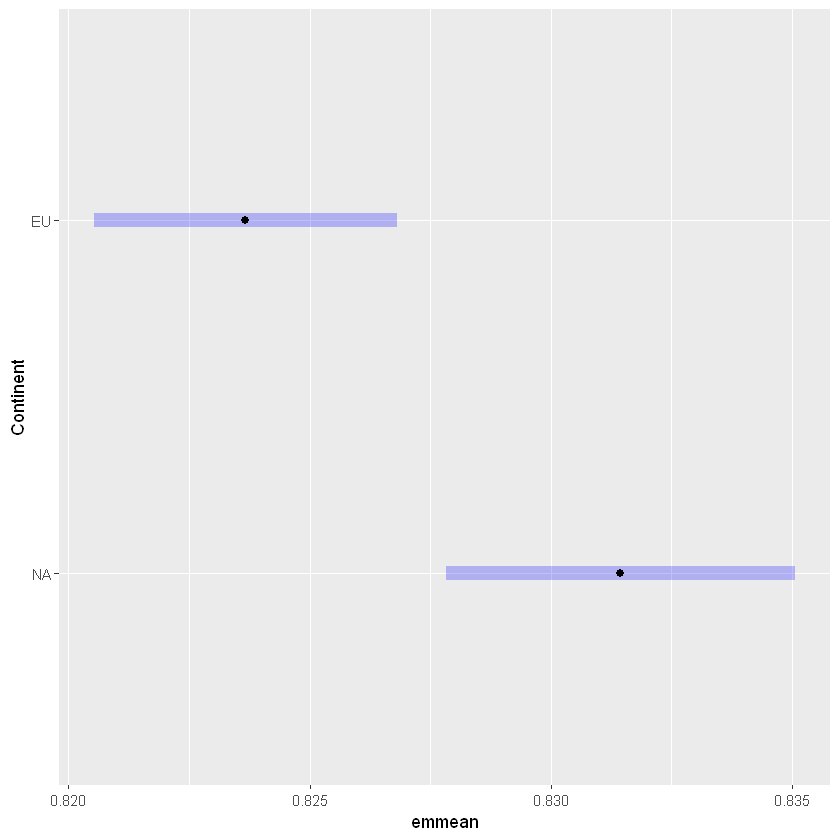

In [17]:
library(car)
library(emmeans) # For calculating marginal means (least-squares means)

# Fit your linear model using lm() function
lm_model <- lm(Ratio ~ Continent, data = ex0918)

# Anova to test the significance of the categorical predictor
anova_result <- Anova(lm_model, type="III")

print(anova_result)

# Calculate marginal (least-squares) means for each level of the categorical predictor
marginal_means <- emmeans(lm_model, specs = ~ Continent, data = ex0918)

print(marginal_means)

plot(marginal_means)

conf_intervals <- confint(marginal_means)

print(conf_intervals)

Z tabulky ANOVA vyplývá, že model zahrnující kategorický prediktor "Kontinent" je statisticky významný (F(1, 19) = 11,525, p = 0,00304), což naznačuje, že existují významné rozdíly v příznaku "Ratio" mezi jednotlivými kontinenty.

Marginal Means pro Severní Ameriku (NA): Odhadovaný průměrný "Ratio" pro pozorování je 0,8314 s 95% intervalem spolehlivosti v rozmezí 0,8278 až 0,8351.
Marginal Means pro Evropu (EU): Odhadovaný průměrný "Ratio" pro pozorování v Evropě je 0,8237 s 95% intervalem spolehlivosti v rozmezí od 0,8205 do 0,8268.

Na základě výsledků ANOVA můžeme říct, že příznak "Ratio" se na jednotlivých kontinentech významně liší. Konkrétně je vyšší v Severní Americe ve srovnání s Evropou, jak naznačují marginal means. To znamená, že kontinent, na kterém je pozorování prováděno, ovlivňuje hodnotu proměnné "Ratio".

Nyní analyzujme R-squared hodnotu. R-squared (koeficient determinace) je měřítkem toho, jak dobře nezávislé proměnné v regresním modelu vysvětlují variabilitu závislé proměnné. Je to užitečná metrika pro hodnocení regresního modelu.

In [18]:
# R-squared value
r_squared <- summary(lm_model)$r.squared

print(paste("R-squared:", round(r_squared, 3)))

[1] "R-squared: 0.378"


R-square ukazuje, že přibližně 37,8 % rozptylu závislé proměnné ("Ratio") je vysvětleno nezávislou proměnnou v našem modelu. Náš model teda vysvětluje střední množství rozptylu závislé proměnné, což je celkem fajn, i když je stále co zlepšovat.

## Úloha 4

Z předchozích dvou bodů máme 2 regresní modely: jeden zkoumá závislost vysvětlované proměnné na numerickém regresoru, druhý na kategoriálním. Naším cílem je nyní tyto dva modely spojit, zjistit jejich parametry a interpretovat je.

In [19]:
# Fit the linear model with both regressors and their interaction
lm_interaction <- lm(Ratio ~ SE.F * Continent, data = ex0918)

# Summarize the model
summary(lm_interaction)


Call:
lm(formula = Ratio ~ SE.F * Continent, data = ex0918)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.013493 -0.001947  0.001236  0.002658  0.010296 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.8334573  0.0090948  91.641   <2e-16 ***
SE.F             -0.0006120  0.0027122  -0.226    0.824    
ContinentEU      -0.0038475  0.0108748  -0.354    0.728    
SE.F:ContinentEU -0.0009022  0.0030839  -0.293    0.773    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005321 on 17 degrees of freedom
Multiple R-squared:  0.4159,	Adjusted R-squared:  0.3128 
F-statistic: 4.035 on 3 and 17 DF,  p-value: 0.02453


Interpretujme koeficienty a prozkoumejme význam jednotlivých složek modelu.

#### Koeficienty modelu

**Intercept**: Intercept představuje odhadovanou střední hodnotu závislé proměnné (Ratio), když jsou všechny ostatní prediktory nulové (tj. SE.F a Continent). V tomto případě je odhadovaná střední hodnota Ratio přibližně 0,833. Tento koeficient je vysoce signifikantní (p < 2e-16), což znamená, že intercept se významně liší od nuly.

**SE.F**: Koeficient SE.F je přibližně -0,000612, ale není statisticky významný (p = 0,824). Z toho plyne, že mezi číselným regresorem SE.F a závislou proměnnou Ratio není významný lineární vztah.

**ContinentEU**: Koeficient pro ContinentEU je přibližně -0,003847, ale není statisticky významný (p = 0,728). To znamená, že mezi EU a NA není významný rozdíl v průměru Ratio.

**Interaction Term (SE.F:ContinentEU)**: Koeficient pro interakční člen SE.F:ContinentEU je přibližně -0,0009022, ale není statisticky významný (p = 0,773). To naznačuje, že interakční účinek mezi SE.F a ContinentEU na poměr není významný.

#### Přizpůsobení modelu

**Multiple R-squared**: je rovna 0,4159, což znamená, že přibližně 41,59 % rozptylu závislé proměnné je vysvětleno prediktory (SE.F, Kontinent a jejich interakce) v modelu.

**Adjusted R-squared**: je rovna 0,3128, což je o něco méně než násobná hodnota R-kvadrátu. Tato hodnota zohledňuje počet prediktorů v modelu a penalizuje za další prediktory, čímž poskytuje konzervativnější odhad dobré shody modelu.

**F-statistic**: F-statistika je 4,035 s p-hodnotou 0,02453, což znamená, že model jako celek je statisticky významný na hladině významnosti 0,001. Tato významnost však nemusí nutně znamenat, že každý jednotlivý prediktor v modelu je významný.

#### Závěr
Intercept je statisticky významný, avšak ani číselný regresor (SE.F), ani kategoriální regresor (Kontinent), ani jejich interakční člen významně nevysvětlují rozptyl závislé proměnné v tomto modelu. Celkový model je statisticky významný, ale nedostatečná významnost jednotlivých prediktorů naznačuje, že tento model nemusí být nejvhodnější pro vysvětlení variability proměnné Ratio.

#### Grafické znázorněni
Jelikož náš model zahrnuje jak číselný regresor (SE.F), tak kategoriální regresor (Continent) spolu s jejich interakčním členem, můžeme vytvořit samostatné grafy rozptylu pro každou kategorii proměnné Continent a zobrazit tak regresní vztah graficky.

`geom_smooth()` using formula = 'y ~ x'


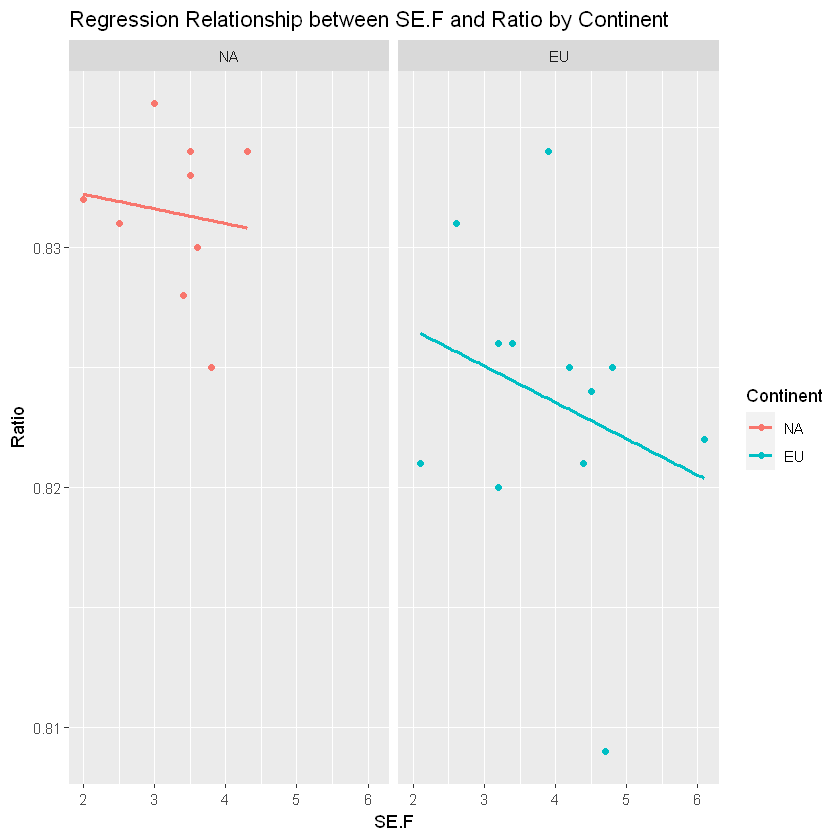

In [20]:
# Generate scatter plots with regression lines for each level of the categorical variable
ggplot(ex0918, aes(x = SE.F, y = Ratio, color = Continent)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  facet_wrap(~ Continent) +
  labs(title = "Regression Relationship between SE.F and Ratio by Continent",
       x = "SE.F", y = "Ratio")

Vidíme bodový graf s dvěma regresními přímkami, které představují odhad vztahu mezi dvěma proměnnými. Obě přímky směřují dolů, což naznačuje záporný vztah, tj. zvýšení hodnoty SE.F je doprovázeno snížením hodnoty Ratio. Rovněž pravá přímka je strmější. Strmost přímky odráží sílu vztahu mezi proměnnými, tj. v Evropě existuje silnější vztah mezi proměnnými Ratio a SE.F. Každý bod na grafu představuje jednotlivé pozorování a je vidět, že v evropských datech je více odlehlých hodnot.

## Úloha 5
V této úloze budeme zkoumat model s předchozími dvěma regresory (číselným regresorem *SE.F* a kategoriálním regresorem *Continent*) a přidáme ostatní regresory.

In [23]:
# Fitování modelu s všemi regresory
fit_all <- lm(Ratio ~ SE.F + Continent + Latitude + Females + Males + SE.M + SE.R, data = ex0918)

# Sumarizace modelu
summary(fit_all)


Call:
lm(formula = Ratio ~ SE.F + Continent + Latitude + Females + 
    Males + SE.M + SE.R, data = ex0918)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0089092 -0.0022860  0.0006879  0.0016972  0.0089463 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.916e-01  1.163e-01   5.949 4.83e-05 ***
SE.F        -3.743e-04  1.701e-03  -0.220  0.82927    
ContinentEU -9.302e-03  2.814e-03  -3.305  0.00569 ** 
Latitude    -3.239e-05  3.244e-04  -0.100  0.92199    
Females      2.988e-04  1.423e-04   2.100  0.05586 .  
Males       -1.535e-04  1.317e-04  -1.166  0.26472    
SE.M        -1.447e-03  1.413e-03  -1.024  0.32453    
SE.R         6.267e-02  2.867e-01   0.219  0.83037    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005043 on 13 degrees of freedom
Multiple R-squared:  0.5988,	Adjusted R-squared:  0.3828 
F-statistic: 2.772 on 7 and 13 DF,  p-value: 0.05346


Z výsledků modelu můžeme vidět, které regresory jsou statisticky významné a které ne:

Statisticky významné regresory:

* **Intercept**: Koeficient interceptu je významný s p-hodnotou 4.83e-05, což naznačuje, že průměrná hodnota Ratio není nulová, když jsou všechny ostatní regresory nulové.

* **ContinentEU**: Proměnná "ContinentEU" má významný vliv na Ratio s p-hodnotou 0.00569, což znamená, že průměrné Ratio se liší mezi kontinenty (Evropou a Severní Amerikou).

Nevýznamné regresory:

* **SE.F, Latitude, Males, SE.M, SE.R**: Tyto regresory mají vysoké p-hodnoty (nad hladinou významnosti 0.05), což naznačuje, že jejich vliv na Ratio není statisticky významný.

* **Females**: Proměnná "Females" má p-hodnotu 0.05586, která je těsně nad hladinou významnosti 0.05. I když tato hodnota není statisticky významná na konvenční úrovni, může stále existovat nějaký vliv Females na Ratio, který by mohl být důležitý při další analýze.


Nevýznamnost musíme interpretovat z hlediska každého z regresorů zvlášť.

Nejdříve vybereme nejméně signifikantní proměnnou z původního modelu. V našem případě, když se podíváme na p-hodnoty, můžeme vidět, že nejméně významnou proměnnou je "Latitude"

In [24]:
fit_all_bez_latitude <- lm(Ratio ~ SE.F + Continent + Females + Males + SE.M + SE.R, data = ex0918)

# Sumarizace modelu
summary(fit_all_bez_latitude)


Call:
lm(formula = Ratio ~ SE.F + Continent + Females + Males + SE.M + 
    SE.R, data = ex0918)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0089437 -0.0021349  0.0007334  0.0015959  0.0087511 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.6993286  0.0840434   8.321 8.64e-07 ***
SE.F        -0.0004060  0.0016108  -0.252  0.80465    
ContinentEU -0.0093277  0.0027018  -3.452  0.00389 ** 
Females      0.0002924  0.0001224   2.388  0.03158 *  
Males       -0.0001575  0.0001209  -1.302  0.21379    
SE.M        -0.0014410  0.0013612  -1.059  0.30769    
SE.R         0.0696205  0.2680808   0.260  0.79888    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.004861 on 14 degrees of freedom
Multiple R-squared:  0.5985,	Adjusted R-squared:  0.4265 
F-statistic: 3.479 on 6 and 14 DF,  p-value: 0.02559


- Obyčejný koeficient determinace `Multiple R-squared` je 0.5985,
- adjustovaný koeficient determinace `Adjusted R-squared` je 0.4265.


Porovnáme s koeficienty determinace původního modelu `fit_all`:

In [25]:
summary(fit_all)$r.squared
summary(fit_all)$adj.r.squared

[1] 0.5988315

[1] 0.3828177

 Porovnáním koeficientů determinace původního modelu (fit_all) a modelu bez nevýznamného regresoru můžeme pozorovat zlepšení v případě adjustovaného koeficientu determinace. To naznačuje, že odstraněním nevýznamného regresoru se snížila složitost modelu a zlepšila jeho schopnost vysvětlit pozorovanou varianci závislé proměnné.

Nicméně, oba modely stále vykazují poměrně nízký koeficient determinace.

Můžeme provést podobnou analýzu pro zbývající regresory a zjistit, zda jejich odstranění vede k dalšímu zlepšení modelu

In [38]:
fit_all_bez_sef <- lm(Ratio ~ Continent + Females + Males + SE.M + SE.R, data = ex0918)

# Sumarizace modelu
summary(fit_all_bez_sef)


Call:
lm(formula = Ratio ~ Continent + Females + Males + SE.M + SE.R, 
    data = ex0918)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0087555 -0.0020760  0.0005857  0.0016038  0.0088425 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.6902299  0.0734901   9.392 1.13e-07 ***
ContinentEU -0.0096092  0.0023821  -4.034  0.00108 ** 
Females      0.0003030  0.0001113   2.721  0.01577 *  
Males       -0.0001588  0.0001170  -1.357  0.19489    
SE.M        -0.0015151  0.0012869  -1.177  0.25742    
SE.R         0.0279050  0.2042142   0.137  0.89313    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.004707 on 15 degrees of freedom
Multiple R-squared:  0.5967,	Adjusted R-squared:  0.4623 
F-statistic: 4.439 on 5 and 15 DF,  p-value: 0.0111


- Obyčejný koeficient determinace `Multiple R-squared` je 0.5967,
- adjustovaný koeficient determinace `Adjusted R-squared` je 0.4623.


Porovnáme s koeficienty determinace původního modelu `fit_all`.

Zdá se, že odstranění dalšího regresoru vedlo ke zlepšení adjustovaného koeficientu determinace, což naznačuje, že nový model lépe vysvětluje variabilitu v datech než původní model.

Nicméně, i když je adjustovaný koeficient determinace vyšší, stále zůstává relativně nízký, což naznačuje, že model možná stále nedokáže plně vysvětlit veškerou variabilitu v datech.

Můžeme provést podobnou analýzu pro zbývající regresory a zjistit, zda jejich odstranění vede k dalšímu zlepšení modelu.

In [87]:
fit_all_bez_ser <- lm(Ratio ~ Continent + Females + Males + SE.M, data = ex0918)

# Sumarizace modelu
summary(fit_all_bez_ser)


Call:
lm(formula = Ratio ~ Continent + Females + Males + SE.M, data = ex0918)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0085981 -0.0017321  0.0005749  0.0019063  0.0089381 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.6889156  0.0705883   9.760 3.85e-08 ***
ContinentEU -0.0095753  0.0022954  -4.172  0.00072 ***
Females      0.0003006  0.0001066   2.820  0.01232 *  
Males       -0.0001540  0.0001083  -1.422  0.17411    
SE.M        -0.0015211  0.0012461  -1.221  0.23989    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.00456 on 16 degrees of freedom
Multiple R-squared:  0.5962,	Adjusted R-squared:  0.4952 
F-statistic: 5.906 on 4 and 16 DF,  p-value: 0.004078


- Obyčejný koeficient determinace `Multiple R-squared` je 0.5962,
- adjustovaný koeficient determinace `Adjusted R-squared` je 0.4952.

Porovnáme s koeficienty determinace původního modelu `fit_all`.
Odstranění dalšího regresoru opět vedlo ke zlepšení adjustovaného koeficientu determinace, což naznačuje, že nový model lépe vysvětluje variabilitu v datech než původní model.

Nicméně, i když je adjustovaný koeficient determinace vyšší, stále zůstává relativně nízký, což naznačuje, že model možná stále nedokáže plně vysvětlit veškerou variabilitu v datech.
Můžeme provést podobnou analýzu pro zbývající regresory a zjistit, zda jejich odstranění vede k dalšímu zlepšení modelu.

In [34]:
fit_all_bez_sem <- lm(Ratio ~ Continent + Females + Males, data = ex0918)

# Sumarizace modelu
summary(fit_all_bez_sem)


Call:
lm(formula = Ratio ~ Continent + Females + Males, data = ex0918)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0087454 -0.0015544 -0.0002749  0.0012745  0.0101988 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.824e-01  7.139e-02   9.558 2.99e-08 ***
ContinentEU -1.007e-02  2.292e-03  -4.395 0.000396 ***
Females      2.377e-04  9.461e-05   2.512 0.022400 *  
Males       -8.196e-05  9.208e-05  -0.890 0.385837    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.004625 on 17 degrees of freedom
Multiple R-squared:  0.5586,	Adjusted R-squared:  0.4807 
F-statistic: 7.171 on 3 and 17 DF,  p-value: 0.002555


- Obyčejný koeficient determinace `Multiple R-squared` je 0.5586,
- adjustovaný koeficient determinace `Adjusted R-squared` je 0.4807.

Jak vidíme, hodnoty jsou menší než v předchozím modelu.


#### Model vs. podmodel
Testujme, zda je možné redukovat původní model `fit_all` na podmodel `fit_all_bez_ser`.

Zkoumáme tak, jestli je rozdíl v reziduálních součtech čtverců významně velký, tedy zda širší model vnáší větší množství variability do dat, než je nezbytně nutné k vysvětlení pozorované variability.

**H0**: Širší model (fit_all) a podmodel (fit_all_bez_ser) mají stejnou schopnost vysvětlit pozorovanou variabilitu dat.

**HA**: Širší model (fit_all) má větší schopnost vysvětlit pozorovanou variabilitu dat než podmodel (fit_all_bez_ser).

In [36]:
anova(fit_all_bez_ser,fit_all)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16,0.0003327314,NA,NA,NA,NA
2,13,0.0003305628,3,2.168598e-06,0.02842806,0.993218


* Residual degrees of freedom (Res.Df): 16 (pro fit_all_bez_ser) a 13 (pro fit_all)
* Residual Sum of Squares (RSS): 0.0003327314 (pro fit_all_bez_ser) a 0.0003305628 (pro fit_all)
* Df: 3 (rozdíl v počtu parametrů mezi modely)
* Sum of Sq: 2.168598e-06 (rozdíl v reziduálních součtech čtverců)
* F-statistic: 0.02842806
* Pr(>F): 0.993218 (p-hodnota testu)

Vzhledem k tomu, že p-hodnota (Pr(>F)) je výrazně vyšší než konvenční hladina významnosti 0.05, nemůžeme zamítnout nulovou hypotézu. To znamená, že není dostatečný statistický důkaz pro tvrzení, že širší model (fit_all) je lepší než podmodel (fit_all_bez_ser). Na základě tohoto testu nelze říci, že redukce modelu je oprávněná.

#### Model s interakcemi
Zkusme v širším modelu `fit_all` přidat i interakce a otestovat, jestli přináší významné zlepšení predikce:

In [71]:
# Fitování modelu s všemi regresory
fit_int_1 <- lm(Ratio ~ SE.F * Continent * Latitude * Females * Males * SE.M * SE.R, data = ex0918)

# Sumarizace modelu
summary(fit_int_1)


Call:
lm(formula = Ratio ~ SE.F * Continent * Latitude * Females * 
    Males * SE.M * SE.R, data = ex0918)

Residuals:
ALL 21 residuals are 0: no residual degrees of freedom!

Coefficients: (107 not defined because of singularities)
                                                    Estimate Std. Error t value
(Intercept)                                       -1.564e+03        NaN     NaN
SE.F                                              -6.262e+01        NaN     NaN
ContinentEU                                        8.732e+01        NaN     NaN
Latitude                                          -5.793e+00        NaN     NaN
Females                                            2.456e+00        NaN     NaN
Males                                              1.664e+00        NaN     NaN
SE.M                                              -6.588e+00        NaN     NaN
SE.R                                               1.006e+02        NaN     NaN
SE.F:ContinentEU                             

V modelu s interakcemi se zdá, že dochází k singularitám, což způsobuje problémy při odhadu koeficientů a výpočtu standardních chyb.

In [99]:
# spojíme některé regresory
fit_int_2 <- lm(Ratio ~ SE.F + SE.M * Continent + Latitude * Females * Males * SE.R, data = ex0918)

# Sumarizace modelu
summary(fit_int_2)


Call:
lm(formula = Ratio ~ SE.F + SE.M * Continent + Latitude * Females * 
    Males * SE.R, data = ex0918)

Residuals:
         1          2          3          4          5          6          7 
 2.826e-04 -1.787e-03  1.777e-03  5.992e-04  3.700e-06  6.903e-04 -3.875e-04 
         8          9         10         11         12         13         14 
-1.147e-03 -3.132e-05  3.150e-04  2.715e-04  4.042e-05  2.850e-04 -1.052e-03 
        15         16         17         18         19         20         21 
-6.849e-06 -2.733e-04  1.026e-04 -9.322e-06  2.247e-04  2.764e-04 -1.739e-04 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)
(Intercept)                  5.397e+02  8.202e+02   0.658    0.629
SE.F                         7.018e-03  5.950e-03   1.179    0.448
SE.M                         6.234e-03  1.257e-02   0.496    0.707
ContinentEU                  2.558e-02  3.897e-02   0.656    0.630
Latitude                    -7.050e+00  1.822e+01  -0.387    

Porovnáme model s interakcemi s modelem bez nich:

**H0**: Neexistuje statisticky významný rozdíl mezi modelem s interakcemi a modelem bez interakcí.

**HA**: Model s interakcemi má statisticky významně lepší vysvětlující schopnost než model bez interakcí.

In [76]:
anova(fit_all,fit_int_2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13,3.305628e-04,NA,NA,NA,NA
2,1,1.033965e-05,12,0.0003202232,2.580867,0.454719


Výsledky testu ANOVA pro srovnání dvou modelů jsou následující:

1. **Model s interakcemi (`fit_int_2`):**
   - Residuální stupeň volnosti (Res.Df): 13
   - Residuální součet čtverců (RSS): 3.305628e-04

2. **Model bez interakcí (`fit_all`):**
   - Residuální stupeň volnosti (Res.Df): 1
   - Residuální součet čtverců (RSS): 1.033965e-05

Testovací statistika F je 2.580867 s p-hodnotou 0.454719.

Pokud je p-hodnota vyšší než zvolená hladina významnosti (např. 0.05), nemůžeme zamítnout nulovou hypotézu, což znamená, že není statisticky významný rozdíl mezi modelem s interakcemi a modelem bez nich. To naznačuje, že model bez interakcí nemusí být signifikantně horší než model s interakcemi.

Můžeme porovnat model s interakcemi s osekaným modelem:

**H0**: Neexistuje statisticky významný rozdíl mezi modelem s interakcemi a osekaným modelem.

**HA**: Model s interakcemi má statisticky významně lepší vysvětlující schopnost než osekaný model.

In [77]:
anova(fit_all_bez_ser,fit_int_2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16,3.327314e-04,NA,NA,NA,NA
2,1,1.033965e-05,15,0.0003223918,2.078676,0.5014636


V porovnání modelu s interakcemi a osekaného modelu jsou výsledky následující:

1. **Osekaný model (`fit_all_bez_ser`):**
   - Residuální stupeň volnosti (Res.Df): 16
   - Residuální součet čtverců (RSS): 3.327314e-04

2. **Model s interakcemi (`fit_int_2`):**
   - Residuální stupeň volnosti (Res.Df): 1
   - Residuální součet čtverců (RSS): 1.033965e-05

Testovací statistika F má hodnotu 2.078676 s p-hodnotou 0.5014636.

P-hodnota je vyšší než standardní hladina významnosti 0.05, což naznačuje, že není statisticky významný rozdíl mezi modelem s interakcemi a osekaným modelem. To znamená, že z pohledu statistické významnosti není důvod preferovat model s interakcemi před osekaným modelem.

#### Test poměrem věrohodností

**H0**: Neexistuje statisticky významný rozdíl v explanační schopnosti mezi osekaným modelem a modelem s všemi regresory.

**HA**: Model s všemi regresory má statisticky významně lepší explanační schopnost než osekaný model.

In [78]:
anova(fit_all_bez_ser,fit_all, test="Chisq")

,Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16,0.0003327314,NA,NA,NA
2,13,0.0003305628,3,2.168598e-06,0.9935429


V testu poměru věrohodností pro porovnání osekaného modelu (`fit_all_bez_ser`) a modelu s všemi regresory (`fit_all`) jsou výsledky následující:

1. **Osekaný model (`fit_all_bez_ser`):**
   - Residuální stupeň volnosti (Res.Df): 16
   - Residuální součet čtverců (RSS): 0.0003327314

2. **Model s všemi regresory (`fit_all`):**
   - Residuální stupeň volnosti (Res.Df): 13
   - Residuální součet čtverců (RSS): 0.0003305628

Testovací statistika Chi-square má p-hodnotu 0.9935429.

P-hodnota je vysoká, což naznačuje, že není statisticky významný rozdíl mezi osekaným modelem a modelem s všemi regresory. To znamená, že z pohledu testu poměru věrohodností není důvod preferovat model s všemi regresory před osekaným modelem.



**H0**: Neexistuje statisticky významný rozdíl v explanační schopnosti mezi osekaným modelem a modelem s interakcemi.

**HA**: Model s interakcemi má statisticky významně lepší explanační schopnost než osekaný model.

In [79]:
anova(fit_all_bez_ser,fit_int_2, test="Chisq")

,Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16,3.327314e-04,NA,NA,NA
2,1,1.033965e-05,15,0.0003223918,0.00830984


V testu poměru věrohodností pro porovnání osekaného modelu (`fit_all_bez_ser`) a modelu s interakcemi (`fit_int_2`) jsou výsledky následující:

1. **Osekaný model (`fit_all_bez_ser`):**
- Residuální stupeň volnosti (Res.Df): 16
- Residuální součet čtverců (RSS): 0.0003327314

2. **Model s interakcemi (`fit_int_2`):**
- Residuální stupeň volnosti (Res.Df): 1
- Residuální součet čtverců (RSS): 0.0003223918

Testovací statistika Chi-square má p-hodnotu 0.00830984.

P-hodnota je nízká, což naznačuje, že existuje statisticky významný rozdíl mezi modelem s interakcemi a osekaným modelem. To znamená, že z pohledu testu poměru věrohodností je **preferován model s interakcemi před osekaným modelem**.

**H0**: Neexistuje statisticky významný rozdíl v explanační schopnosti mezi modelem se všemi regresory a modelem s interakcemi.

**HA**: Model se všemi regresory má statisticky významně lepší explanační schopnost než model s interakcemi.

In [81]:
anova(fit_all,fit_int_2, test="Chisq")

,Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13,3.305628e-04,NA,NA,NA
2,1,1.033965e-05,12,0.0003202232,0.001990584


V testu poměru věrohodností pro porovnání modelu se všemi regresory (`fit_all`) a modelu s interakcemi (`fit_int_2`) jsou výsledky následující:

1. **Model se všemi regresory (`fit_all`):**
- Residuální stupeň volnosti (Res.Df): 13
- Residuální součet čtverců (RSS): 0.0003305628

2. **Model s interakcemi (`fit_int_2`):**
- Residuální stupeň volnosti (Res.Df): 1
- Residuální součet čtverců (RSS): 0.0003223918

Testovací statistika Chi-square má p-hodnotu 0.001990584.

P-hodnota je nízká, což naznačuje, že existuje statisticky významný rozdíl mezi modelem se všemi regresory a modelem s interakcemi. To znamená, že z pohledu testu poměru věrohodností je **preferován model se všemi regresory před modelem s interakcemi**.

#### Informační kritéria
spočítáme Akaikeho a Bayesovské informační kritérium pro použité modely (bez interakcí, zjednodušená verze, s interakcemi).

In [82]:
AIC(fit_all, fit_all_bez_ser, fit_int_2)

,df,AIC
,<dbl>,<dbl>
fit_all,9,-154.6485
fit_all_bez_ser,6,-160.5112
fit_int_2,21,-203.4096


In [83]:
BIC(fit_all, fit_all_bez_ser, fit_int_2)

,df,BIC
,<dbl>,<dbl>
fit_all,9,-145.2478
fit_all_bez_ser,6,-154.2441
fit_int_2,21,-181.4746


Podle obou kritérií je model `fit_int_2` nejšikovnější.

#### Sekvenční výběr
Zvolíme vhodně minimální a maximální model a nalezněte optimální model pomocí sekvenčního výběru.

In [104]:
step(lm(Ratio~1,data=ex0918),scope=list(lower=~1,upper=~SE.F + SE.M * Continent + Latitude * Females * Males * SE.R))

Start:  AIC=-211.06
Ratio ~ 1

            Df  Sum of Sq        RSS     AIC
+ Continent  1 3.1111e-04 0.00051289 -219.02
+ SE.F       1 1.1930e-04 0.00070470 -212.35
<none>                    0.00082400 -211.06
+ SE.M       1 1.3303e-05 0.00081070 -209.41
+ SE.R       1 1.0098e-05 0.00081390 -209.32
+ Males      1 9.5170e-06 0.00081448 -209.31
+ Females    1 6.0070e-06 0.00081799 -209.22
+ Latitude   1 5.2170e-06 0.00081878 -209.20

Step:  AIC=-219.02
Ratio ~ Continent

            Df  Sum of Sq        RSS     AIC
+ Females    1 1.3222e-04 0.00038067 -223.28
<none>                    0.00051289 -219.02
+ Latitude   1 3.8323e-05 0.00047457 -218.65
+ SE.F       1 2.9151e-05 0.00048374 -218.25
+ Males      1 1.4185e-05 0.00049870 -217.61
+ SE.M       1 2.6800e-07 0.00051262 -217.03
+ SE.R       1 1.8000e-08 0.00051287 -217.02
- Continent  1 3.1111e-04 0.00082400 -211.06

Step:  AIC=-223.28
Ratio ~ Continent + Females

            Df  Sum of Sq        RSS     AIC
<none>                    


Call:
lm(formula = Ratio ~ Continent + Females, data = ex0918)

Coefficients:
(Intercept)  ContinentEU      Females  
  0.6627105   -0.0102966    0.0001862  


#### Interpretace

* Koeficient pro **ContinentEU** je -0.0102966. To znamená, že pro jednotkový nárůst v kategorické proměnné ContinentEU se očekává průměrný pokles výsledné proměnné Ratio o 0.0102966 jednotek, za předpokladu, že všechny ostatní proměnné zůstávají stejné.
* Koeficient pro **Females** je 0.0001862. To znamená, že pro jednotkový nárůst v počtu žen se očekává průměrný nárůst výsledné proměnné Ratio o 0.0001862 jednotek, za předpokladu, že všechny ostatní proměnné zůstávají stejné.

Tento výsledný model obsahuje pouze dvě proměnné - Continent a Females - a je vybrán na základě sekvenčního výběru, který minimalizoval hodnotu AIC.

## Úloha 6
Pro ověření předpokladů modelu můžeme použít několik testů.
Začněme získáním reziduí z finálního modelu:

In [106]:
# Finální model
final_model <- lm(Ratio ~ Continent + Females, data = ex0918)

# Získání reziduí
residuals <- resid(final_model)

Nyní provedeme jednotlivé testy:

Normalita reziduí:

**H0**: Rezidua pocházejí z normálního rozdělení.

**HA**: Rezidua nejsou z normálního rozdělení.

In [107]:
# Shapiro-Wilkův test
shapiro.test(residuals)


	Shapiro-Wilk normality test

data:  residuals
W = 0.96411, p-value = 0.6024


Vypadá to, že test normálnosti Shapiro-Wilk pro rezidua nemá důkazy proti normální distribuci (p-hodnota = 0,6024). To naznačuje, že rezidua našeho modelu mohou být aproximována normálním rozdělením.

Absence multicolinearity mezi prediktory:

In [111]:
# Spočítání VIF
vif(final_model)

Continent   Females 
 1.246774  1.246774

To naznačuje, že tyto proměnné mají menší vliv na normalitu reziduí.

Můžeme tedy konstatovat, že předpoklad normality residuí pro náš model nebyl porušen.

Použijeme Breusch-Pagan test pro testování homoskedasticity

**H0**: Rezidua jsou homoskedastická (mají konstantní rozptyl).

**HA**: Rezidua nejsou homoskedastická (mají proměnný rozptyl).

In [116]:
library(lmtest)

# Předpoklad homoskedasticity pomocí Breusch-Pagan testu
bptest(final_model)


	studentized Breusch-Pagan test

data:  final_model
BP = 0.90466, df = 2, p-value = 0.6361


Výsledek studentizovaného Breusch-Pagan testu na finálním modelu naznačuje, že není nalezena statisticky významná evidence proti homoskedasticitě reziduí (p-hodnota = 0.6361). To naznačuje, že neexistují důkazy o tom, že rozptyl reziduí je závislý na hodnotách nezávislých proměnných, a model tedy může splňovat předpoklad homoskedasticity.